In [2]:
''' import libraries '''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pycce as pc
import ase
import warnings
from mpl_toolkits import mplot3d
from ase.build import bulk
import pycce.filter
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib as mpl

import time

"""set up seed for bath generations"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=10)


coord = np.arange(-5,6,1)
depth = (50+(3.57*np.sqrt(3)*coord))/10

#######################################################################################################################
########## 5 electrons ##########
#######################################################################################################################
T2_E_5 = []
T2_err_E_5 = []
n=0
for j in coord:
    n = n+1
    starttime = time.perf_counter()
    ''' generate layer of 5 electrons within a thin 10x10x1 nm^3 layer '''
    electron_layer = pc.random_bath('e', [1e2, 1e2, 10], 
                                        density=5e19, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [j, j, j]),('C', [j+0.5, j+0.5, j+0.5])],
                                  add=('14N', [j+0.5, j+0.5, j+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 180  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [j,j,j]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 1, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    T2_fit = np.abs(T2_gen[0])*1000
    T2_err = T2_var[0][0]*1000
    
    T2_E_5.append(T2_fit)
    T2_err_E_5.append(T2_err)
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)
    
    distance = (50+(3.57*np.sqrt(3)*j))/10
    
    plt.figure()
    plt.plot(time_space_generatilze_fixed, l_generatilze_fixed)
    plt.plot(time_space,coherence_fit(time_space,T2_fit), label='$T_2$ = {0:0.6f} $\pm$ {1:0.6f} $\mu$s'.format(T2_fit,T2_err))
    plt.xlabel('Coherence')
    plt.ylabel('Time (ms)')
    plt.legend(loc='best')
    plt.title(distance)
    
# plots the data points and the fitted  curve
plt.figure()
plt.errorbar(depth, T2_E_5, yerr=T2_err_E_5, label='N = 5')
plt.legend()
plt.xlabel('Number of electrons')
plt.ylabel('$T_2$ (ms)')

#######################################################################################################################
########## 10 electrons ##########
#######################################################################################################################
T2_E_10 = []
T2_err_E_10 = []
n=0
for j in coord:
    n = n+1
    starttime = time.perf_counter()
    ''' generate layer of 10 electrons within a thin 10x10x1 nm^3 layer '''
    electron_layer = pc.random_bath('e', [1e2, 1e2, 10], 
                                        density=1e20, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [j, j, j]),('C', [j+0.5, j+0.5, j+0.5])],
                                  add=('14N', [j+0.5, j+0.5, j+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [j,j,j]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 1, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    T2_fit = np.abs(T2_gen[0])*1000
    T2_err = T2_var[0][0]*1000
    
    T2_E_10.append(T2_fit)
    T2_err_E_10.append(T2_err)
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)
    
    distance = (50+(3.57*np.sqrt(3)*j))/10
    
    plt.figure()
    plt.plot(time_space_generatilze_fixed, l_generatilze_fixed)
    plt.plot(time_space,coherence_fit(time_space,T2_fit), label='$T_2$ = {0:0.6f} $\pm$ {1:0.6f} $\mu$s'.format(T2_fit,T2_err))
    plt.xlabel('Coherence')
    plt.ylabel('Time (ms)')
    plt.legend(loc='best')
    plt.title(distance)
    
# plots the data points and the fitted  curve
plt.figure()
plt.errorbar(depth, T2_E_10, yerr=T2_err_E_10, label='N = 10')
plt.legend()
plt.xlabel('Number of electrons')
plt.ylabel('$T_2$ (ms)')

#######################################################################################################################
########## N = 50 ##########
#######################################################################################################################
T2_E_50 = []
T2_err_E_50 = []
n=0
for j in coord:
    n = n+1
    starttime = time.perf_counter()
    ''' generate layer of 10 electrons within a thin 10x10x1 nm^3 layer '''
    electron_layer = pc.random_bath('e', [1e2, 1e2, 10], 
                                        density=5e20, density_units='cm-3', 
                                        center=[50,50,60], seed=seed)
    
    ''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
    # Generate unitcell from ase
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    
    # Add types of isotopes
    diamond.add_isotopes(('13C', 0.011))
    
    # Add the defect. remove and add atoms at the positions (in cell coordinates) 
    atoms = diamond.gen_supercell(100, remove=[('C', [j, j, j]),('C', [j+0.5, j+0.5, j+0.5])],
                                  add=('14N', [j+0.5, j+0.5, j+0.5]), seed=seed)
    
    """setup for coherence calculation"""
    
    # Parameters of CCE calculations engine
    
    # Order of CCE aproximation
    order = 2
    # Bath cutoff radius
    r_bath = 150  # in A
    # Cluster cutoff radius
    r_dipole = 50  # in A
    
    # Qubit levels (in Sz basis)
    alpha = [0, 0, 1]; beta = [0, 1, 0]
    
    # ZFS Parametters of NV center in diamond
    D = 2.88 * 1e6 # in kHz
    E = 0 # in kHz
    
    # position of central spin
    position = [j,j,j]
    
    # generate central spin
    nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)
    
    # Setting the runner engine
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,electron_layer]),
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "coherence calculation"
    
    "general"
    # Time points
    time_space = np.linspace(0, 0.001, 201)  # in ms
    
    # Mag. Field (Bx By Bz)
    b = np.array([0,0,500])  # in G
    
    # Hahn-echo pulse sequence
    pulse_sequence = [pc.Pulse('x', np.pi)]
    
    # Calculate coherence function with general method
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                                 pulses=pulse_sequence,
                                 method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    "fitting a negative squared exponential"
    def coherence_fit(x,T2):
        "fit coherence function to a negative squared exponential function with time constant T2"
        fit = np.exp(-(x/T2)**2)
        return fit
    
    #popt: Optimized parameters
    #pcov: matrix of covariance.
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    T2_fit = np.abs(T2_gen[0])*1000
    T2_err = T2_var[0][0]*1000
    
    T2_E_50.append(T2_fit)
    T2_err_E_50.append(T2_err)
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)
    
    distance = (50+(3.57*np.sqrt(3)*j))/10
    
    plt.figure()
    plt.plot(time_space_generatilze_fixed, l_generatilze_fixed)
    plt.plot(time_space,coherence_fit(time_space,T2_fit), label='$T_2$ = {0:0.6f} $\pm$ {1:0.6f} $\mu$s'.format(T2_fit,T2_err))
    plt.xlabel('Coherence')
    plt.ylabel('Time (ms)')
    plt.legend(loc='best')
    plt.title(distance)
    
# plots the data points and the fitted  curve
plt.figure()
plt.errorbar(depth, T2_E_50, yerr=T2_err_E_50, label='N = 50')
plt.legend()
plt.xlabel('Number of electrons')
plt.ylabel('$T_2$ (ms)')

############################################################################################################################

'save data'
datasavefile = 'datapoints_T2_E_depth.csv'
data_E_T2 = {'depth':depth, 'T2_E_10':T2_E_10, 'T2_err_E_10':T2_err_E_10, 
                            'T2_E_50':T2_E_50, 'T2_err_E_50':T2_err_E_50, 
                            'T2_E_5':T2_E_5, 'T2_err_E_5':T2_err_E_5}


df = pd.DataFrame(data = data_E_T2)
df.to_csv(datasavefile)

# plots the data points and the fitted  curve
plt.style.use('plot_style.txt')

plt.figure()
plt.errorbar(depth, T2_E_5, yerr=T2_err_E_5, fmt='^', ecolor='k', elinewidth=1, capsize=5, label='N = 5')
plt.errorbar(depth, T2_E_10, yerr=T2_err_E_10, fmt='o', ecolor='k', elinewidth=1, capsize=5, label='N = 10')
plt.errorbar(depth, T2_E_50, yerr=T2_err_E_50, fmt='x', ecolor='k', elinewidth=1, capsize=5, label='N = 50')
plt.legend()
plt.xlabel('Depth (nm)')
plt.ylabel('$T_2$ (ms)')

C:\Users\Daniel Low\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


-5291.760419499999 secs for calc 1
-5106.5626281 secs for calc 2
-1853.5536365000007 secs for calc 3
-1686.0291306999989 secs for calc 4


C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:172: RuntimeWarning: overflow encountered in power
  vcalc = contribution_operator(vcalc, current_power[index])
C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:174: RuntimeWarning: invalid value encountered in multiply
  result = result_operator(result, vcalc)


-1679.8884411 secs for calc 5
-1553.8796660999997 secs for calc 6
-1530.3518288999985 secs for calc 7
-1619.6206471000005 secs for calc 8
-1512.1533056999979 secs for calc 9
-1537.1513214000006 secs for calc 10
-1551.1651633999973 secs for calc 11
-2126.5785060000017 secs for calc 1
-1504.1154715999983 secs for calc 2
-1571.535300800002 secs for calc 3
-1671.6318108999985 secs for calc 4
-1598.3190854000022 secs for calc 5
-1635.2071167999966 secs for calc 6
-1598.1628353999986 secs for calc 7
-1563.2126499000005 secs for calc 8
-1533.064029999994 secs for calc 9


C:\Users\Daniel Low\Anaconda3\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1551.8431448999982 secs for calc 10
-1490.5732389999976 secs for calc 11


C:\Users\Daniel Low\Anaconda3\lib\site-packages\ipykernel_launcher.py:259: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1399.4082968000002 secs for calc 1


C:\Users\Daniel Low\Anaconda3\lib\site-packages\ipykernel_launcher.py:369: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1463.855362000002 secs for calc 2
-1367.4191011000003 secs for calc 3
-1438.969107099998 secs for calc 4
-1351.9204886000007 secs for calc 5
-1315.5387418000028 secs for calc 6
-1312.981231800004 secs for calc 7
-1304.5363306 secs for calc 8
-1296.0498957000018 secs for calc 9
-1296.9770076999994 secs for calc 10
-1318.9620397000035 secs for calc 11


C:\Users\Daniel Low\Anaconda3\lib\site-packages\ipykernel_launcher.py:378: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\Daniel Low\Anaconda3\lib\site-packages\ipykernel_launcher.py:399: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Text(0, 0.5, '$T_2$ (ms)')

Text(0.5, 1.0, '8.091710691510446')

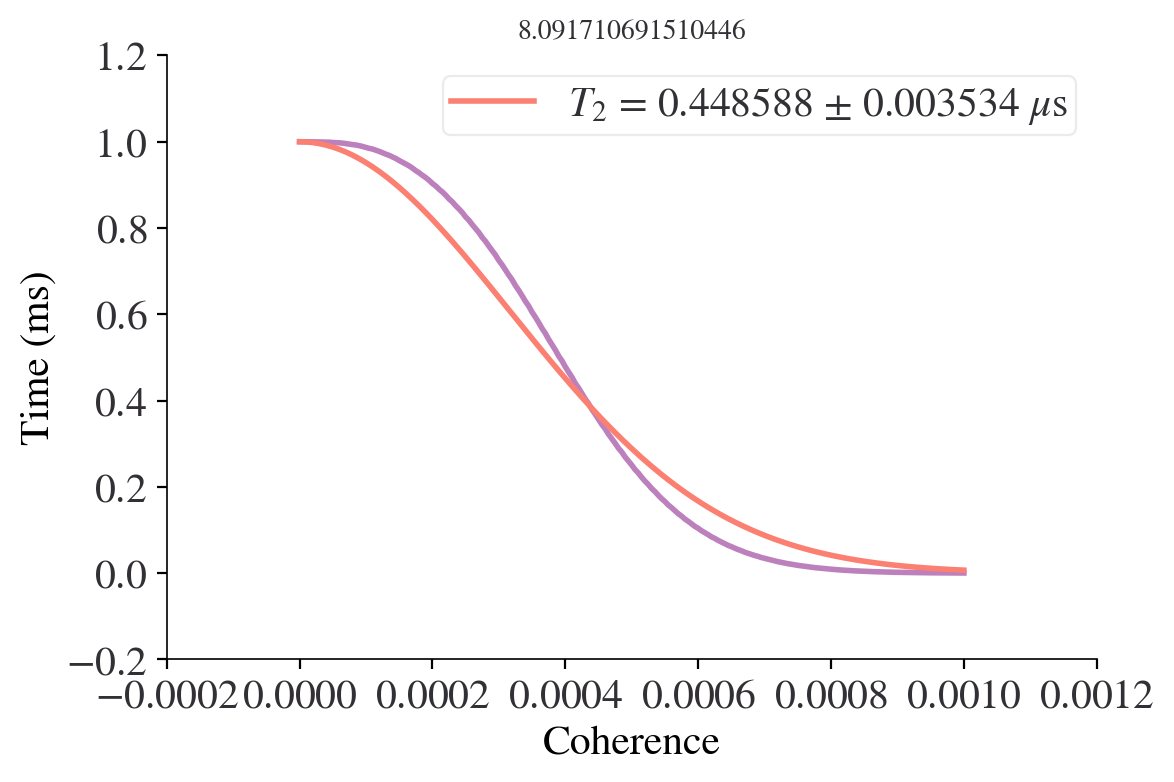

In [7]:
plt.figure()
plt.plot(time_space_generatilze_fixed, l_generatilze_fixed)
plt.plot(time_space,coherence_fit(time_space,T2_fit/1000), label='$T_2$ = {0:0.6f} $\pm$ {1:0.6f} $\mu$s'.format(T2_fit,T2_err))
plt.xlabel('Coherence')
plt.ylabel('Time (ms)')
plt.legend(loc='best')
plt.title(distance)


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


    Unnamed: 0     depth     T2_E_10  T2_err_E_10   T2_E_50  T2_err_E_50  \
0            0  1.908289  286.354636    15.910178  0.295800     0.002437   
1            1  2.526631  286.493915    15.440882  0.308852     0.002524   
2            2  3.144974  278.536677    14.806049  0.322163     0.002614   
3            3  3.763316  219.300152    11.772874  0.335812     0.002709   
4            4  4.381658   20.052164     4.816424  0.349375     0.002816   
5            5  5.000000  156.258443    11.355951  0.363766     0.002926   
6            6  5.618342  240.202013    13.360252  0.379109     0.003038   
7            7  6.236684  244.432651    14.793963  0.394607     0.003163   
8            8  6.855026  267.921867    14.573067  0.409746     0.003303   
9            9  7.473369  338.366150    15.258347  0.429260     0.003409   
10          10  8.091711  421.831927    15.957409  0.448588     0.003534   

        T2_E_5  T2_err_E_5  
0   725.880293    4.464541  
1   742.280856    5.739660  


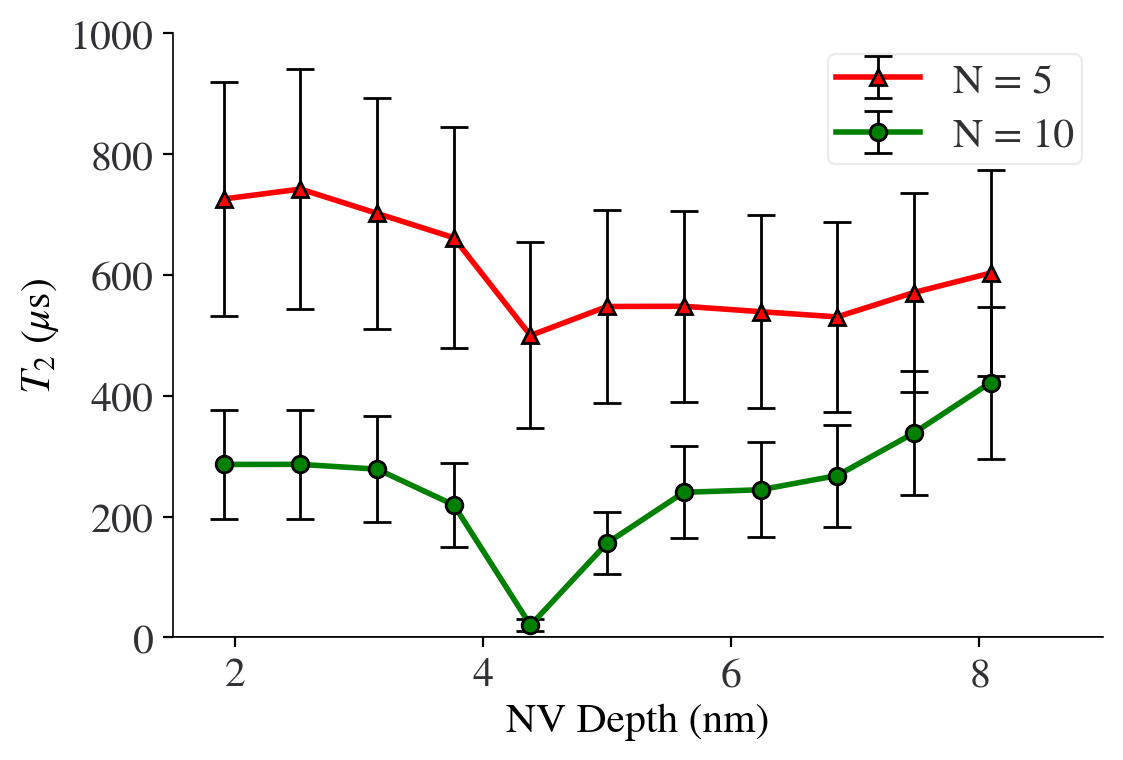

In [40]:
plt.style.use('plot_style.txt')

datasavefile = 'datapoints_T2_E_depth.csv'
data_T2_E_depth = pd.read_csv(datasavefile)
print(data_T2_E_depth)

T2_popfiterror = 0.26045948996093372

fit_E,fit_COV = np.polyfit(np.log(depth), np.log(T2_E_50),1,full = False, cov = True)
print(fit_E)
print(fit_COV)
fit_err_E = np.sqrt(fit_COV[0][0])
print(fit_E[0], '$\pm$', fit_err_E, '$\mu$s/nm')

X = np.linspace(1,9,200)
Y_E = np.exp(fit_E[1])*(X**fit_E[0])

plt.figure()
plt.plot(X,Y_E, 'k',linewidth=0.75)
plt.errorbar(depth, T2_E_5, yerr=T2_err_E_5+np.multiply(T2_E_5,T2_popfiterror), fmt='r^-', ecolor='k', elinewidth=1, capsize=5, label='N = 5')
plt.errorbar(depth, T2_E_10, yerr=T2_err_E_10+np.multiply(T2_E_10,T2_popfiterror), fmt='go-', ecolor='k', elinewidth=1, capsize=5, label='N = 10')
# plt.errorbar(depth, T2_E_50, yerr=T2_err_E_50+np.multiply(T2_E_50,T2_popfiterror), fmt='bs-', ecolor='k', elinewidth=1, capsize=5, label='N = 50')
# plt.yscale('log')
plt.legend()
plt.xlabel('NV Depth (nm)')
plt.xlim(1.5,9)
plt.ylim(0,1000)
# plt.text(3,0.6, r'0.29 $\pm$ 0.02 $\mu$s/nm')
plt.ylabel('$T_2$ ($\mu$s)')

outpath = 'datapoints_T2_E_depth_magnified.png'
plt.savefig(outpath)

In [8]:
print(T2_E_50)

[0.002615798614017922, 0.002828145296203493, 0.0029303749915842573, 0.002839348902464162, -0.002973269505122941, 0.0032591039355949814, 0.0032419136969763355, 0.003365191755159839, 0.0036872895765752973, 0.004017028628036717, 0.0042390832341644685]



Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Text(0, 0.5, '$T_2$ (ms)')

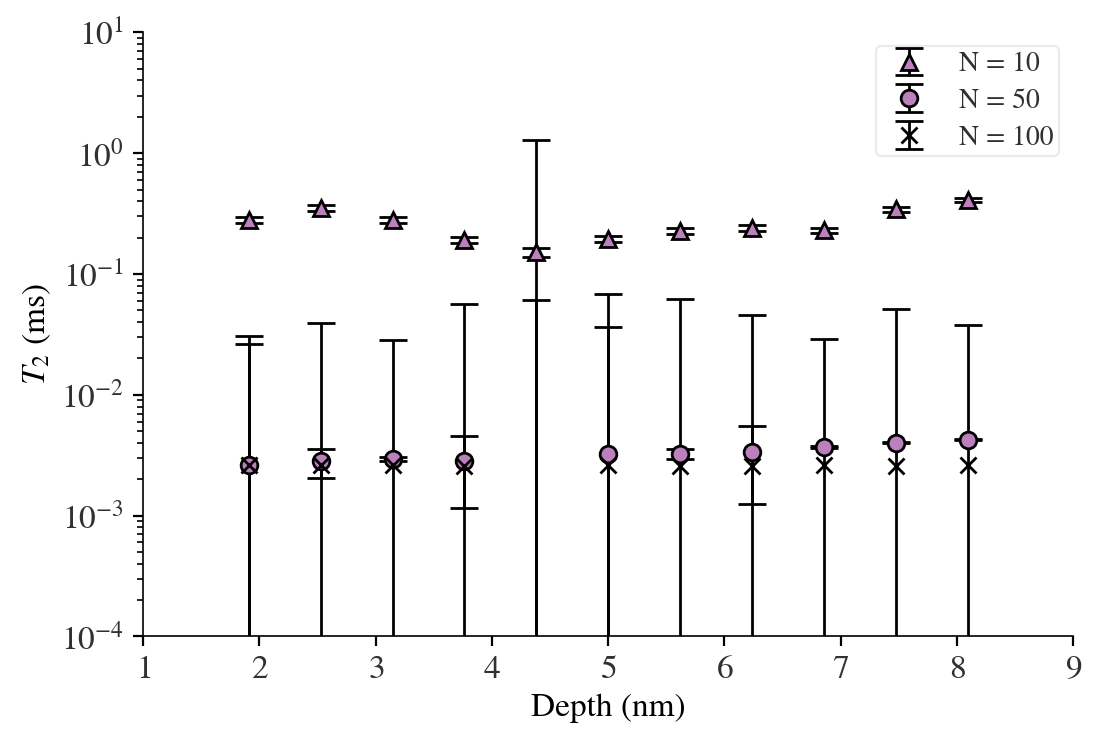

In [11]:
plt.style.use('plot_style.txt')

plt.figure()
plt.errorbar(depth, T2_E_10, yerr=T2_err_E_10, fmt='^', ecolor='k', elinewidth=1, capsize=5, label='N = 10')
plt.errorbar(depth, T2_E_50, yerr=T2_err_E_50, fmt='o', ecolor='k', elinewidth=1, capsize=5, label='N = 50')
plt.errorbar(depth, T2_E_100, yerr=T2_err_E_100, fmt='x', ecolor='k', elinewidth=1, capsize=5, label='N = 100')
plt.yscale('log')
plt.legend()
plt.xlabel('Depth (nm)')
plt.ylabel('$T_2$ (ms)')